### dependencies

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Get Adj Close column
df = pd.read_csv('../../data/clean/djia_stock_data.csv', header=[0,1], index_col=0)
df_adjclose = df['Adj Close']
df_adjclose.head()

Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.320435,120.226593,15.4260,80.133865,113.657204,70.110153,58.910961,20.189039,73.464256,86.310020,...,40.152481,42.353619,0.483143,67.861961,79.629883,84.121574,86.560966,61.672878,27.908205,23.441490
2015-01-05,23.635284,118.797897,15.1095,78.014641,112.870071,66.409309,57.846901,19.786867,70.527763,85.048737,...,39.783249,41.671707,0.474983,67.539314,79.393250,83.108360,85.135162,60.311527,27.676430,23.373260
2015-01-06,23.637510,114.970551,14.7645,76.352020,111.540627,65.981995,56.882286,19.779552,70.495117,84.597618,...,39.199341,41.426579,0.460582,67.231644,79.153549,82.366409,84.963387,59.922901,27.955755,23.553373
2015-01-07,23.968960,118.985886,14.9210,78.019562,113.272369,67.004478,56.613789,19.962358,70.436417,85.463020,...,39.697369,42.282307,0.459382,67.584343,80.503761,83.770576,85.830872,60.725742,27.775352,24.178303
2015-01-08,24.889904,118.557266,15.0230,79.125473,115.275284,67.691254,58.264568,20.115919,72.048218,86.346840,...,40.865200,43.258358,0.476663,68.357216,82.706612,85.509781,89.927879,61.540249,28.370665,24.688610


In [3]:
# Select target stock
df_adjclose_aapl = df_adjclose[['AAPL']]

# Transform index into Datetime
df_adjclose_aapl.index = pd.to_datetime(df_adjclose_aapl.index)
print(type(df_adjclose_aapl.index))
df_adjclose_aapl.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Ticker,AAPL
Date,
2015-01-02,24.320435
2015-01-05,23.635284
2015-01-06,23.637510
2015-01-07,23.968960
2015-01-08,24.889904


In [4]:
def create_features(df: pd.DataFrame, stock: str):
    """Creates time series features from the 'Adj Close' column."""
    output_df = df.copy(deep=True)

    output_df['lag_1'] = df[stock].shift(1)       # Value from yesterday
    # output_df['lag_7'] = df[stock].shift(7)       # Value from last week
    # output_df['lag_30'] = df[stock].shift(30)      # Value from last month

    # output_df['rolling_mean_5'] = df[stock].rolling(window=5).mean().shift(1)
    # output_df['rolling_mean_50'] = df[stock].rolling(window=50).mean().shift(1)

    # output_df['volatility_5'] =  df[stock].rolling(window=5).std()
    # output_df['volatility_50'] =  df[stock].rolling(window=50).std()

    # output_df['EMA_50'] =  df[stock].ewm(span=50).mean()     # Exponential Moving Average

    output_df.columns.name = 'Variables'
    output_df = output_df.rename(columns={stock: stock+'_AdjClose'})

    return output_df

In [5]:
# Create input features
transformed_df = create_features(df_adjclose_aapl, 'AAPL')
print(transformed_df.shape)

# Add Volume
# df_volume = df['Volume']
# df_volume_aapl = df_volume[['AAPL']]
# transformed_df['volume_pct_change'] = df_volume_aapl.pct_change().values

# Drop missing values due to lags
transformed_df.dropna(inplace=True)
print(transformed_df.shape)
transformed_df.head()

(2515, 2)
(2514, 2)


Variables,AAPL_AdjClose,lag_1
Date,,
2015-01-05,23.635284,24.320435
2015-01-06,23.637510,23.635284
2015-01-07,23.968960,23.637510
2015-01-08,24.889904,23.968960
2015-01-09,24.916597,24.889904


In [6]:
# Export
transformed_df.to_csv('../../data/clean/transformed_df_for_RF.csv')

In [7]:
# Train Test Split
X = transformed_df.drop('AAPL_AdjClose', axis=1)  # Features
y = transformed_df['AAPL_AdjClose']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

### Random Forest

In [8]:
# Fit model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [9]:
# Prediction
y_pred = rf_model.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Mean Absolute Error: %.3f' % mae)
print('Mean Squared Error: %.3f' % mse)

Mean Absolute Error: 18.782
Mean Squared Error: 813.502


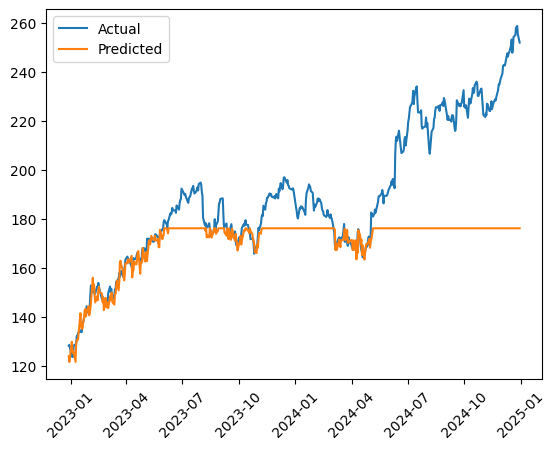

In [10]:
# Plot Test Results
plt.plot(y_test, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.xticks(rotation=45)
plt.legend()
plt.show()